## Importing the necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import Dataset, DataLoader, random_split

## Downloading the dataset

In [ ]:
transform = transforms.ToTensor()

In [ ]:
train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True,transform = transform)
test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform = transform)

100%|██████████| 562M/562M [00:23<00:00, 24.3MB/s]


In [ ]:
train_dataset.data.shape, train_dataset.targets.shape

(torch.Size([124800, 28, 28]), torch.Size([124800]))

## Performing the data split

In [ ]:
train_dataset.targets -= 1
test_dataset.targets -= 1

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])

X_train = train_data.dataset.data.float() / 255.0
y_train = train_data.dataset.targets

X_val = val_data.dataset.data.float() / 255.0
y_val = val_data.dataset.targets

X_test = test_dataset.data.float() / 255.0
y_test = test_dataset.targets

In [ ]:
train_dataset_final = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset_final = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset_final = torch.utils.data.TensorDataset(X_test, y_test)

## Making the train and test loader

In [ ]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Defining custom Neural Network Class

In [ ]:
class MyNN(nn.Module):
  def __init__(self, input_dim,output_dim):
    super(MyNN, self).__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.bn1 = nn.BatchNorm1d(128)

    self.fc2 = nn.Linear(128, 64)
    self.bn2 = nn.BatchNorm1d(64)

    self.fc4 = nn.Linear(64, output_dim)

    self.relu = nn.ReLU()

    self.dropout = nn.Dropout(0.3)


  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.bn1(self.fc1(x))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.bn2(self.fc2(x))
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc4(x)
    return x

Creating the model inside `model` variable

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = MyNN(input_dim=784,output_dim=26).to(device)

## Defining the criterion and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Defining the training and evaluation loop

In [ ]:
def evaluate(loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
from tqdm import tqdm

In [ ]:
def train(epochs, criterion, optimizer):
  train_loss = []
  train_acc_list =[]
  val_acc_list =[]
  for epoch in range(epochs):
    model.train()

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
    for batch_idx, (data, target) in enumerate(loop):
      data = data.view(data.size(0), -1)
      data, target = data.to(device), target.to(device)

      optimizer.zero_grad()

      output = model(data)
      loss = criterion(output, target)
      train_loss.append(loss.item())

      loss.backward()
      optimizer.step()

    train_acc = evaluate(train_loader)
    val_acc = evaluate(val_loader)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] |Train Loss : {loss.item()}| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
  return train_loss, train_acc_list, val_acc_list

In [ ]:
train_loss, train_acc, val_acc = train(10, criterion, optimizer)

Epoch [1/10] |Train Loss : 0.6621877551078796| Train Acc: 0.8328 | Val Acc: 0.8255


Epoch [2/10] |Train Loss : 0.809486985206604| Train Acc: 0.8496 | Val Acc: 0.8417


Epoch [3/10] |Train Loss : 0.9426664710044861| Train Acc: 0.8689 | Val Acc: 0.8570


Epoch [4/10] |Train Loss : 0.6454674601554871| Train Acc: 0.8744 | Val Acc: 0.8624


Epoch [5/10] |Train Loss : 0.6018849611282349| Train Acc: 0.8780 | Val Acc: 0.8655


Epoch [6/10] |Train Loss : 0.8132064938545227| Train Acc: 0.8799 | Val Acc: 0.8663


Epoch [7/10] |Train Loss : 0.7188725471496582| Train Acc: 0.8816 | Val Acc: 0.8670


Epoch [8/10] |Train Loss : 0.6278088092803955| Train Acc: 0.8874 | Val Acc: 0.8713


Epoch [9/10] |Train Loss : 0.6917391419410706| Train Acc: 0.8945 | Val Acc: 0.8774


Epoch [10/10] |Train Loss : 0.8421674966812134| Train Acc: 0.8902 | Val Acc: 0.8762


In [ ]:
test_acc = evaluate(test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")

Final Test Accuracy: 0.8777


In [ ]:
import matplotlib.pyplot as plt

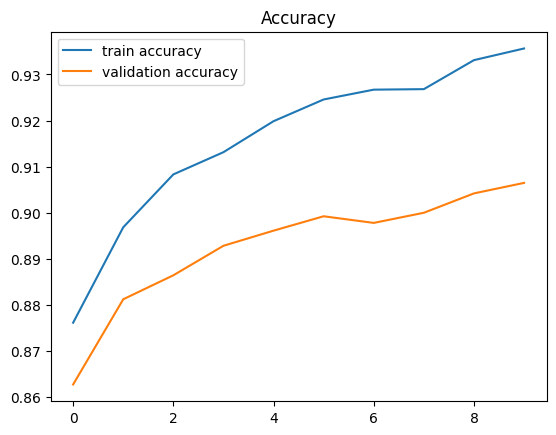

In [ ]:
plt.plot(train_acc, label = "train accuracy")
plt.plot(val_acc, label = "validation accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

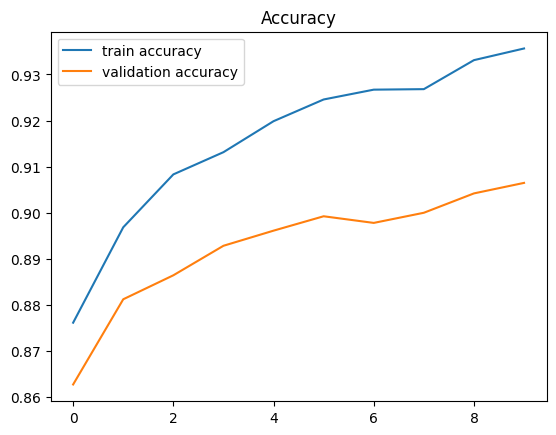